In [25]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# GPU test

In [26]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# test

with tf.device('/device:GPU:1'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)

Num GPUs Available:  1


# Imports

In [27]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os
from PIL import Image
import pathlib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib
import math
import cv2

with tf.device('/device:GPU:1'):

  #tf.enable_eager_execution() # --> needed if TF version < 2.0

  %matplotlib inline

  # INPUT_DIR = '/content/drive/My Drive/Cactus'
  # TRAIN_IMG_DIR = INPUT_DIR+'/train/'
  # PRED_IMG_DIR = INPUT_DIR+'/test/'

  AUTOTUNE = tf.data.experimental.AUTOTUNE

  np.random.seed(1000)

# Path

In [28]:
with tf.device('/device:GPU:1'):

  labels = pd.read_csv('/content/drive/My Drive/Cactus/train.csv')
  sub = pd.read_csv('/content/drive/My Drive/Cactus/sample_submission.csv')
  train_path = '/content/drive/My Drive/Cactus/train/'
  test_path = '/content/drive/My Drive/Cactus/test/'



In [29]:
with tf.device('/device:GPU:1'):

  print('Num train samples:{0}'.format(len(os.listdir(train_path))))
  print('Num test samples:{0}'.format(len(os.listdir(test_path))))

Num train samples:17500
Num test samples:4000


In [30]:
labels.head() # show head of dataset

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [31]:
labels['has_cactus'].value_counts() # to know proportions of cactus

1    13136
0     4364
Name: has_cactus, dtype: int64

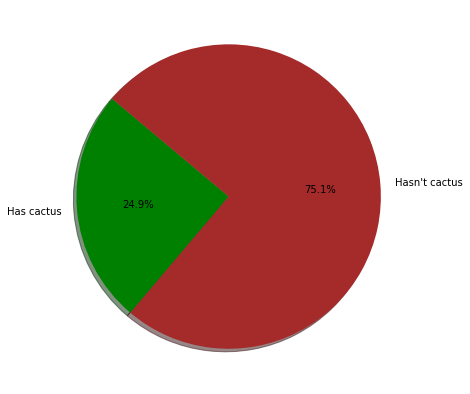

In [32]:
lab = 'Has cactus','Hasn\'t cactus'
colors=['green','brown']

plt.figure(figsize=(7,7))
plt.pie(labels.groupby('has_cactus').size(), labels=lab,
        labeldistance=1.1, autopct='%1.1f%%',
        colors=colors,shadow=True, startangle=140)
plt.show()

# Has Cactus

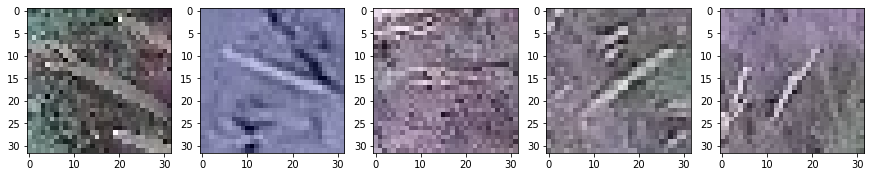

In [33]:
fig,ax = plt.subplots(1,5,figsize=(15,3))

for i, idx in enumerate(labels[labels['has_cactus']==1]['id'][-5:]):
  path = os.path.join(train_path,idx)
  ax[i].imshow(cv2.imread(path)) # [...,[2,1,0]]

# Has no cactus 

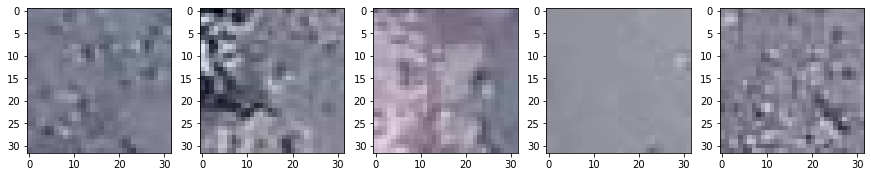

In [34]:
fig,ax = plt.subplots(1,5,figsize=(15,3))

for i, idx in enumerate(labels[labels['has_cactus']==0]['id'][-5:]):
  path = os.path.join(train_path,idx)
  ax[i].imshow(cv2.imread(path)) # [...,[2,1,0]]

# Deep Learning Part

In [35]:
from sklearn.model_selection import train_test_split
with tf.device('/device:GPU:1'):

# Hyper parameters
  num_epochs = 25
  num_classes = 2
  batch_size = 128
  learning_rate = 0.002


In [36]:
with tf.device('/device:GPU:1'):

  # data splitting
  train, val = train_test_split(labels, stratify=labels.has_cactus, test_size=0.1)


  n_training_items = train['id'].count()
  n_testing_items = val['id'].count()

train.shape, val.shape

((15750, 2), (1750, 2))

In [37]:
train['has_cactus'].value_counts()

1    11822
0     3928
Name: has_cactus, dtype: int64

In [38]:
val['has_cactus'].value_counts()


1    1314
0     436
Name: has_cactus, dtype: int64

# Creating Slices

In [39]:
def img_path(img_file, img_type=0):
    """ 
    img_file: name of image file
    img_type: 0 if for training, 1 for evaluation dataset.
    """
    if img_type==0:
        return train_path +img_file
    else:
        return test_path +img_file

with tf.device('/device:GPU:1'):

  # Find the filename and corresponding labels of all images in training dataset.
  train_image_paths = [img_path(x) for x in train['id']] # Split train set --> train part
  train_image_labels = [x for x in train['has_cactus']]

  # Find the filename and corresponding labels of all images in testing dataset.
  test_image_paths = [img_path(x) for x in val['id']] # Split train set --> val part
  test_image_labels = [x for x in val['has_cactus']]



  # Find the filenames of all prediction files.
  path = os.listdir(test_path)

  pred_images_paths = [img_path(x, 1) for x in path] # Submission images --> called test here need to be homogeneated
  n_pred_items = len(pred_images_paths)


# Check images type

JPEG (32, 32) RGB


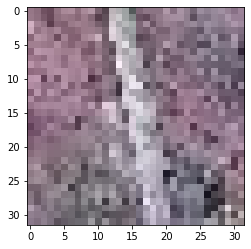

In [40]:
im = Image.open(train_image_paths[0])
print(im.format, im.size, im.mode)
imgplot = plt.imshow(im)

# Custom Generator

Note : Preprocessing come before Dataset creation

TensorShape([96, 96, 3])

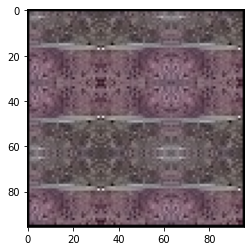

In [41]:
def load_and_preprocess_image(imagefile):

  def prepocess_image(image):
    
    def normalize_tensor(tensor,mean,std):

      mean_tensor = tf.constant(mean, shape=[1,3])
      std_tensor = tf.constant (std, shape=[1,3])
      tensor = tf.math.subtract(tensor, mean_tensor, name= None)
      tensor = tf.math.divide(tensor,std_tensor, name=None)

      

      return tensor

    image = tf.image.decode_jpeg(image,channels=3) # R,G,B mode, .jpeg format
    image = tf.pad(image, paddings=[[31,31],[31,31],[0,0]] , mode='REFLECT', name=None)
    image = tf.pad(image, paddings=[[1,1],[1,1],[0,0]], mode='CONSTANT', name =None)
    image = image / 255 # when imported with Pytorch images are scaled between 0.0 and 1.0
    #image = normalize_tensor(image,[0.5,0.5,0.5],[0.5,0.5,0.5])

      
    return image

  image = tf.io.read_file(imagefile)
  return prepocess_image(image)

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label



load_and_preprocess_image('/content/drive/My Drive/Cactus/train/a84ae1dd950ecec162dc72412bd36fd0.jpg')


plt.imshow(load_and_preprocess_image('/content/drive/My Drive/Cactus/train/a84ae1dd950ecec162dc72412bd36fd0.jpg'))

load_and_preprocess_image('/content/drive/My Drive/Cactus/train/a84ae1dd950ecec162dc72412bd36fd0.jpg').shape

# Creating Input Pipeline

In [42]:
with tf.device('/device:GPU:1'):

  # Tensorflow Dataset containing all image paths and labels
  train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
  test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_image_labels))
  pred_ds = tf.data.Dataset.from_tensor_slices(pred_images_paths)


  # Load the images into dataset from the path in the dataset
  train_ds = train_ds.map(load_and_preprocess_from_path_label)
  test_ds = test_ds.map(load_and_preprocess_from_path_label)
  pred_ds = pred_ds.map(load_and_preprocess_image)

  # for element in train_ds.as_numpy_iterator():
  #   print(element)

print(train_ds)



<MapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int32)>


# Model Implementation

In [43]:
with tf.device('/device:GPU:1'):

  model = keras.Sequential([
                            
                            keras.layers.Conv2D(filters = 32, kernel_size= 3, padding='valid', activation = tf.nn.leaky_relu, input_shape=(96,96,3)),
                            keras.layers.ZeroPadding2D(padding=(2, 2)),
                            tf.keras.layers.BatchNormalization(momentum = 0.1, epsilon = 1e-05),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
                            #####
                            keras.layers.Conv2D(filters = 64, kernel_size= 3, padding='valid', activation = tf.nn.leaky_relu, input_shape=(49,49,32)),
                            keras.layers.ZeroPadding2D(padding=(2, 2)),
                            tf.keras.layers.BatchNormalization(momentum = 0.1, epsilon = 1e-05),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'),
                            #####
                            keras.layers.Conv2D(filters = 128, kernel_size= 3, padding='valid', activation = tf.nn.leaky_relu, input_shape=(25,25,64)),
                            tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
                            tf.keras.layers.BatchNormalization(momentum = 0.1, epsilon = 1e-05),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'),
                            #####
                            keras.layers.Conv2D(filters = 256, kernel_size= 3, padding='valid', activation = tf.nn.leaky_relu, input_shape=(13,13,128)),
                            tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
                            tf.keras.layers.BatchNormalization(momentum = 0.1, epsilon = 1e-05),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'),
                            #####
                            keras.layers.Conv2D(filters = 512, kernel_size= 3, padding='valid', activation = tf.nn.leaky_relu, input_shape=(7,7,256)),
                            tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
                            tf.keras.layers.BatchNormalization(momentum = 0.1, epsilon = 1e-05),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'),
                            #####
                            tf.keras.layers.AveragePooling2D(pool_size=(3,3),strides=None, padding='valid'),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(units=2, activation='linear')




                            
                            
                            
                            ])

  model.compile(optimizer=keras.optimizers.Adamax(learning_rate=0.002),loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

  model.build((None,96,96,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 98, 98, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 98, 98, 32)        128       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 51, 51, 64)       

# Model training

In [44]:
with tf.device('/device:GPU:1'):

  # train the model

  # Hyper parameters
  num_epochs = 25
  num_classes = 2
  batch_size = 128


  steps_per_epoch = int(math.ceil(n_training_items/batch_size))
  # Training Dataset
  train_ds1 = (train_ds.cache()
              .apply(
                  tf.data.experimental.shuffle_and_repeat(buffer_size=n_training_items)
              )
              .batch(batch_size)
              .prefetch(buffer_size=AUTOTUNE)
              )

  # Testing dataset
  test_ds1 = (test_ds.cache()
              .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=n_training_items))
              .batch(batch_size)
              .prefetch(buffer_size=AUTOTUNE))

  # Prediction dataset
  pred_ds1 = (pred_ds
              .cache()
              .batch(batch_size)
              .prefetch(buffer_size=AUTOTUNE)
            )

print(train_ds1, pred_ds1)

with tf.device('/device:GPU:1'):


  model.fit(train_ds1, epochs=num_epochs, steps_per_epoch=steps_per_epoch)


<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int32)> <PrefetchDataset shapes: (None, None, None, 3), types: tf.float32>
Epoch 1/25
124/124 [==============================] - 32s 82ms/step - loss: 1.6581 - accuracy: 0.7024
Epoch 2/25
124/124 [==============================] - 10s 83ms/step - loss: 1.3515 - accuracy: 0.8456
Epoch 3/25
124/124 [==============================] - 10s 82ms/step - loss: 0.9479 - accuracy: 0.8748
Epoch 4/25
124/124 [==============================] - 10s 82ms/step - loss: 0.5359 - accuracy: 0.8987
Epoch 5/25
124/124 [==============================] - 10s 82ms/step - loss: 0.4007 - accuracy: 0.9101
Epoch 6/25
124/124 [==============================] - 10s 83ms/step - loss: 0.6059 - accuracy: 0.8851
Epoch 7/25
124/124 [==============================] - 10s 83ms/step - loss: 0.4859 - accuracy: 0.9555
Epoch 8/25
124/124 [==============================] - 10s 83ms/step - loss: 0.4724 - accuracy: 0.9209
Epoch 9/25
124/124 [=======

# Save Model Parameters

In [45]:
# Saving model

model.save_weights('/content/drive/MyDrive/Cactus/TF_checkpoint_GPU')

# Testing Phase

In [46]:
with tf.device('/device:GPU:1'):

  model.evaluate(test_ds1, steps=n_testing_items)

1750/1750 [==============================] - 61s 33ms/step - loss: 0.0458 - accuracy: 0.9920


# Prediction & Submission

In [48]:
with tf.device('/device:GPU:1'):

  path = os.listdir(test_path)

  logits = model.predict(pred_ds1, steps=n_pred_items)
  predictions = np.argmax(logits, axis=-1)
  print(path)
  names = np.array([x for x in path])
  pred_df = pd.DataFrame(
      {
          "id":names,
          "has_cactus":predictions
      })
  #pred_df.head()

['c0ee36887889a803a3be20aca76820e1.jpg', 'c07bf2fd75c7d11068b70c20c46df28b.jpg', 'c0d852d57a4c0e3dd92c57d43a406656.jpg', 'c0346b34684ebe1efafe70ead726360f.jpg', 'c07dbe8f11c8714ecb3ff2a84eb02fb6.jpg', 'c184ff3c7eb664296b538c560091893a.jpg', 'c19a73411004ea29f4f248a89881b0f9.jpg', 'c1bc236b00d9c99e6a4315b8ec03ce6d.jpg', 'c1860d0f821d4733c186c8db7371d8f5.jpg', 'c155761e03bd1e12bb5013e702570363.jpg', 'c1289f4470563c021cab6594c1dca269.jpg', 'c1b1c1f6960809e7e86463fd04ced432.jpg', 'c133af795b85f45a6e1010ddbc3493a2.jpg', 'c1cd97843f918c8483930374614d2611.jpg', 'c16162b0ceb5585533670ba19ab1b247.jpg', 'c1a68c13491d75acb15d8ac465278696.jpg', 'c14dc0d0266dbc5703d1b31ecf0be02d.jpg', 'c1c699fadc9746977854ad34c747ded5.jpg', 'c14b34fedfbe1ade076309e2752cd015.jpg', 'c122bef1c76c903cbfdc5302ac0dea7c.jpg', 'c1a0f4eee85933112caefe7037586fc3.jpg', 'c1b61e0262e9454c0965952085d5a873.jpg', 'c21a5535cfde825d063466b8dbcc8c7d.jpg', 'c1dbbb4cca99db3d2b775ed473ceaf57.jpg', 'c1fe7ea3d5d30d111ba82ec645b04971.jpg',